In [1]:
import os

import random
import numpy as np
import keras

from matplotlib.pyplot import imshow
import tensorflow as tf
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
import matplotlib.pyplot as plt

import cv2
import tensorflow.keras.backend as K
from skimage.transform import resize

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [7]:
#Create the transfer learned model
model = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=True)

Conv_Layer_Name = 'block5_conv4'

gb_model = tf.keras.models.Model(
    inputs = [model.inputs],    
    outputs = [model.get_layer(Conv_Layer_Name).output]
)
layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]

@tf.custom_gradient
def guidedRelu(x):
  def grad(dy):
    return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
  return tf.nn.relu(x), grad

for layer in layer_dict:
  if layer.activation == tf.keras.activations.relu:
    layer.activation = guidedRelu

574726144/574710816 [==============================] - 3s 0us/step


In [9]:
def outConvNeuron(in_image):
  # Preprocess the image using vgg19 preprocess function
  img =  tf.keras.preprocessing.image.img_to_array(in_image)
  x = np.expand_dims(img, axis=0)
  preprocessed_input = tf.keras.applications.vgg19.preprocess_input(x)

  with tf.GradientTape() as tape:
    inputs = tf.cast(preprocessed_input, tf.float32)
    tape.watch(inputs)
    outputs = gb_model(inputs)[0]

  grads = tape.gradient(outputs,inputs)[0]

  weights = tf.reduce_mean(grads, axis=(0, 1))
  grad_cam = np.ones(outputs.shape[0: 2], dtype = np.float32)
  for i, w in enumerate(weights):
      grad_cam += w * outputs[:, :, i]

  grad_cam_img = cv2.resize(grad_cam.numpy(), (224, 224))
  grad_cam_img = np.maximum(grad_cam_img, 0)
  heatmap = (grad_cam_img - grad_cam_img.min()) / (grad_cam_img.max() - grad_cam_img.min())
  grad_cam_img = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
  output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, grad_cam_img, 1, 0)

  plt.imshow(output_image)
  plt.axis("off")
  plt.title("Grad Cam output Image")
  plt.show()

  #Visualizing the guided back prop
  guided_back_prop =grads
  gb_viz = np.dstack((
              guided_back_prop[:, :, 0],
              guided_back_prop[:, :, 1],
              guided_back_prop[:, :, 2],
          ))       
  gb_viz -= np.min(gb_viz)
  gb_viz /= gb_viz.max()
      
  imgplot = plt.imshow(gb_viz)
  plt.axis("off")
  plt.title("Guided Back Propagation Oi98 tput Image")
  plt.show()

  guided_cam = np.maximum(grad_cam, 0)
  guided_cam = guided_cam / np.max(guided_cam) # scale 0 to 1.0
  guided_cam = resize(guided_cam, (224,224), preserve_range=True)
  #pointwise multiplcation of guided backprop and grad CAM 
  gd_gb = np.dstack((
          guided_back_prop[:, :, 0] * guided_cam,
          guided_back_prop[:, :, 1] * guided_cam,
          guided_back_prop[:, :, 2] * guided_cam,
      ))
  imgplot = plt.imshow(gd_gb)
  plt.axis("off")
  plt.title("Guided Cam output Image")
  plt.show() 

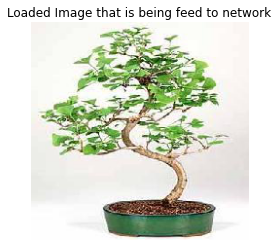

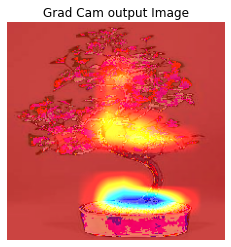

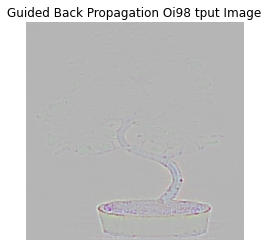

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


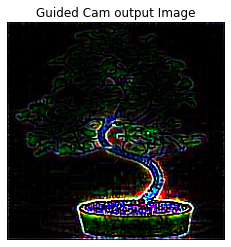

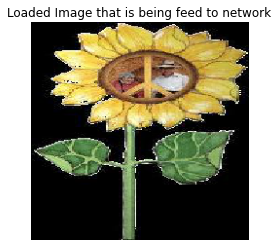

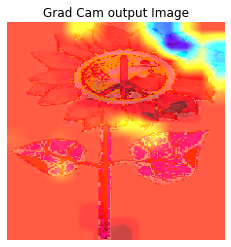

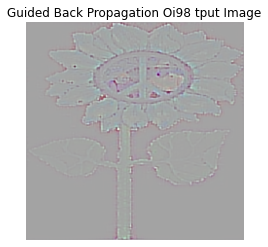

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


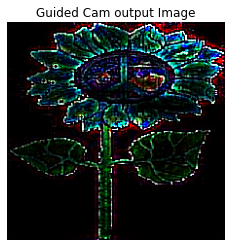

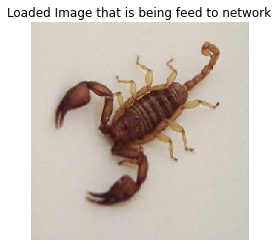

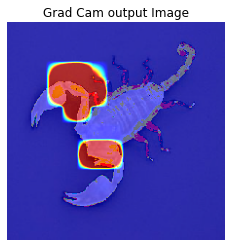

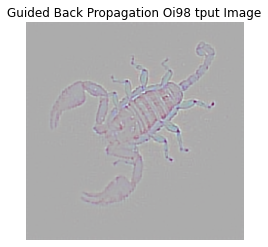

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


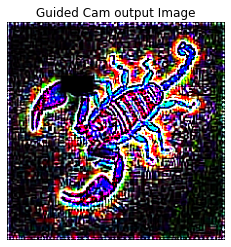

In [10]:
#Setting the image path and the last conv layer for VGG19
dir_path = '/content/gdrive/My Drive/Colab Notebooks/Deep Learning  - Sem 2/Assignment 3/Group_24/train'
IMAGE_PATH = ['bonsai/image_0004.jpg', 'sunflower/image_0004.jpg', 'scorpion/image_0020.jpg']

for img_path in IMAGE_PATH:
  #Load the image
  img = tf.keras.preprocessing.image.load_img(os.path.join(dir_path, img_path), target_size=(224, 224))
  # Displaying the original image
  plt.axis("off")
  plt.imshow(img)
  plt.title("Loaded Image that is being feed to network")
  plt.show()

  # To print the Grad Cam and other outputs
  outConvNeuron(img)